In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

In [2]:
#nbx
using BenchmarkTools;
using Colors, Plots;
col = palette(:default);
(cgrad::PlotUtils.ContinuousColorGradient)(xs::Vector{Vector{Float64}}) = [cgrad[x] for x in xs];
(cgrad::PlotUtils.ContinuousColorGradient)(m::Matrix{Float64}) = reshape(cgrad[m[:]], size(m));
using Gen
using GridSlam
using Geometry
using MyUtils

In [220]:
argdiffs(bs::Array{T,1}) where T <: Real = Tuple(map(b -> Bool(b) ? UnknownChange() : NoChange(), bs));

In [3]:
include("src/load_data.jl")

Loading `../data/data_4.jld2` ...

	_segs 	Vector{Segment}
	_boxes 	Vector{Segment}
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


In [13]:
segs_  = CuArray(stack(Vector.(_segs)));
boxes_ = CuArray(stack(Vector.(_boxes)));
ps_    = CuArray(stack(Vector.(_ps)));

## Plotting

In [122]:
function Plots.plot!(p::Pose; r=0.5, args...)
    plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
end

function Plots.plot!(ps::Vector{Pose}, cs::Vector{RGBA{Float64}}; r=0.5, args...)
    myplot=nothing
    for (p,c) in zip(ps,cs)
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)];c=c, args...)
    end
    return myplot
end

function Plots.plot!(ps::Vector{Pose}; r=0.5, args...)
    myplot=nothing
    for p in ps
        myplot = plot!([p.x, p.x + r*unit_vec(p.hd)]; args...)
    end
    return myplot
end

## Distributions we need

In [5]:
#nbx
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src")
using GenDistributionZoo: ProductDistribution, diagnormal

mvuniform = ProductDistribution(uniform);
mvuniform(zeros(5), ones(5))

5-element Vector{Float64}:
 0.06804330344918696
 0.7711379899183475
 0.4528407621410131
 0.31991146077608146
 0.250938573787002

## Model parts

### Pose-prior model

In [6]:
#nbx --fname="src/pose_prior_model.jl"
_bb = bounding_box(_segs);

"""
    p = pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45.)

Model depends on global variable `_segs`.
"""
@gen function pose_prior_model(p=nothing, x_noise=0.25, hd_noise=45/360*2π, bb=_bb)
    if p == nothing
        x  ~ mvuniform(bb...)
        hd ~ uniform(0,2π)
    else
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    end
    return Pose(x, hd)
end;

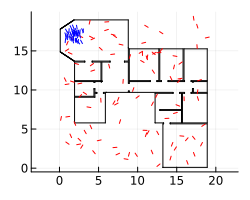

In [7]:
ps = [pose_prior_model(nothing) for t=1:100]
qs = [pose_prior_model(_ps[1], .5, 15/360*2π) for t=1:50]

# ----------------------
plot(size=(250,200), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps,c=:red)
plot!(qs,c=:blue)

### Control Prior

In [8]:
#nbx
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;

In [9]:
control_prior_model(0.10, 45/360*2π)

Control([0.18578910555813766, 0.10489847380525102], -0.42385853410593927)

### Motion model

In [10]:
#nbx --fname="src/motion_model.jl"
"""
    p′ = motion_model(p, u, x_noise=0.25, hd_noise=22.5)

Sample a new pose `p′` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise` (in degrees).
"""
@gen function motion_model(p, u, x_noise=0.25, hd_noise=45/360*2π)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return p = Pose(x, hd)
end;

### Sensor model

In [256]:
include("src/sensor.jl")

In [35]:
_fov = 2π
_as = [range(-_fov/2, _fov/2, 361)...];
as_ = CuArray(_as);

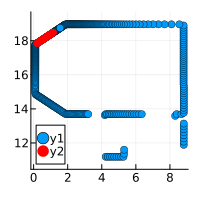

In [19]:
w = 20
m = 2*w+1
t = 1
i = 40

z_       = cast_cu(ps_, vcat(segs_))
z_tilde_ = slw_cu!(z_, w; blockdims=(8,8,4))

z       = Array(z_)
z_tilde = Array{Float64}(z_tilde_)

ys        = polar_inv(z[t,:], _as)
ys_tilde  = polar_inv(z_tilde[t,i,:], _as[i-w:i+w])

# ----------------------
plot(size=(200,200), aspect_ratio=:equal)
scatter!(ys.*_ps[t])
scatter!(ys_tilde.*_ps[t], c=:red, markerstrokewidth=0)

In [39]:
#nbx
@gen function sensor_model_cu(p, segs_, w, s_noise, outlier, outliver_vol=1.0)
    p_  = CuArray(Vector(p))
    ps_ = reshape(p_, 1, 3)
    zs_ = cast_cu(ps_, segs_; fov=_fov)
    
    y_tilde_ = get_ys_tilde_cu(zs_, as_, w)[1,:,:,:]
    x ~ sensordist_cu(y_tilde_, s_noise, outlier, outliver_vol)
    
    return x
end

DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Any, Any, Any, Any, Any, Any], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, Some(1.0)], var"##sensor_model_cu#464", Bool[0, 0, 0, 0, 0, 0], false)

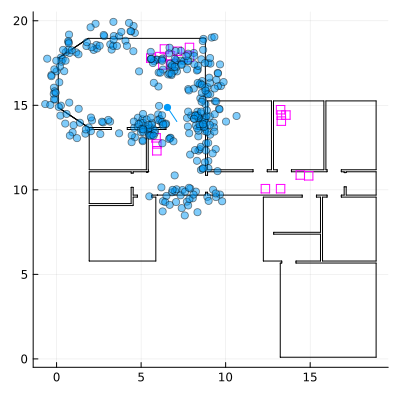

In [358]:
w            = 5
s_noise      = 0.5
outlier      = 0.1
outliver_vol = 1.0

t = 7

x = sensor_model_cu(_ps[t], vcat(segs_,boxes_), w, s_noise, outlier, outliver_vol)

# -------------------------------
plot(size=(400,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs,c=:black)
plot!(_boxes,c=:magenta)
scatter!(x.*_ps[t], c=col[1], alpha=0.5)
scatter!(_ps[t], c=col[1])

## Static Model

In [79]:
#nbx
@gen function slam_kernel(t, state, m, us, x_noise, hd_noise, w, s_noise, outlier, outliver_vol)
    
        p,_ = state
        u = us[t]
    
        p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
        x  = {:sensor} ~ sensor_model_cu(p, m, w, s_noise, outlier, outliver_vol)
        
    return (p, x)
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions

In [81]:
#nbx
"""
    [(p,z),...] = static_slam_model(T, ...)

Static SLAM model ...
"""
@gen (static) function static_slam_model(T, 
        m,
        us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, outlier, outliver_vol)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model_cu(p, m, w, s_noise, outlier, outliver_vol) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, nothing), m, us, 
        x_noise, hd_noise, 
        w, s_noise, outlier, outliver_vol)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions

In [92]:
#nbx
function constraints(t::Int, _zs, _as)
    ch = choicemap()
    if t==0
        addr  = :sensor => :x
    else
        addr  = :chain => t => :sensor => :x
    end
    n = length(_zs[t+1])
    x = polar_inv(_zs[t+1],_as)
    ch[addr] = x
    return ch
end

constraints (generic function with 2 methods)

In [83]:
#nbx
get_pose(tr,t)     = tr[][t][1]
get_last_pose(tr)  = tr[][end][1]
get_first_pose(tr) = get_pose(tr,1)

get_x(tr,t)     = tr[][t][2]
get_first_x(tr) = get_x(tr,1)

get_first_x (generic function with 1 method)

In [89]:
unstack(x::Matrix) = [x[i,:] for i=1:size(x,1)]

unstack (generic function with 1 method)

In [90]:
zs_ = cast_cu(ps_, vcat(segs_,boxes_); fov=_fov)
_zs = unstack(Array(zs_));

In [211]:
T = 0

p0 = _ps[1]
x0_noise = 1.00
hd0_noise = 25/360*2π

x_noise = 0.1
hd_noise = 10.

wind = 10
s_noise = 0.1
outlier = 0.0
outlier_vol=1.0

ch = constraints(0,_zs,_as)

args = (
#     vcat(segs_,boxes_), 
    segs_, 
    _us,         
    p0, x0_noise, hd0_noise,               # Pose prior model
    x_noise, hd_noise,                     # Motion model
    wind, s_noise, outlier, outliver_vol   # Sensor model
)


@time tr, w = generate(static_slam_model, (T, args...), ch);

  0.001615 seconds (1.14 k allocations: 71.562 KiB)


In [216]:
trs, ws, lml = importance_sampling(static_slam_model, (T, args...), ch, 1_000);


perm = sortperm(ws)
trs = trs[perm]
ws=ws[perm]

ps = get_first_pose.(trs);


In [217]:
peak_to_peak

peak_to_peak (generic function with 1 method)

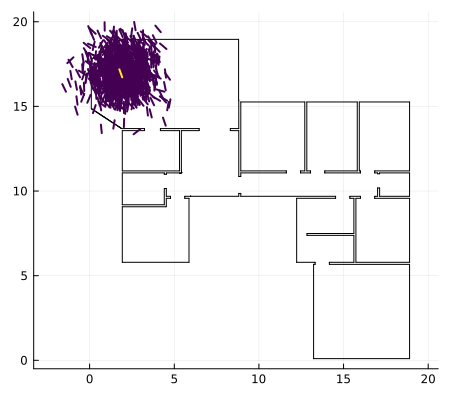

In [219]:

cs = cgrad(:viridis)[exp.(ws)]
# ----------------------
plot(size=(450,400), aspect_ratio=:equal, legend=nothing)
plot!(_segs, c=:black)
plot!(ps, cs, r=0.5, linewidth=2)
# plot!(p0, c=:red, r=0.5, linewidth=3)

## SMC grid proposal

### Pose grid

In [255]:
dx  = 0.1
dhd = 0.1
k = 3
collect(range(-dx*(k-1)/2, dx*(k-1)/2, k))

3-element Vector{Float64}:
 -0.1
  0.0
  0.1

In [237]:
#nbx
"""
    ps_ = pose_grid(p, k, dx, dhd)

Returns CuArray of pose vectors (k^3, 3).
"""
function pose_grid(p, k, dx, dhd)

    dx1_ = CUDA.collect(CUDA.range(- dx*(k-1)/2,  dx*(k-1)/2, k))
    dx2_ = CUDA.collect(CUDA.range(- dx*(k-1)/2,  dx*(k-1)/2, k))
    dhd_ = CUDA.collect(CUDA.range(-dhd*(k-1)/2, dhd*(k-1)/2, k))
    dx1_ = CuArray(dx1_)
    dx2_ = CuArray(dx2_)
    dhd_ = CuArray(dhd_)
    dx1_ = CUDA.repeat(reshape(dx1_, k,1,1), 1,k,k)
    dx2_ = CUDA.repeat(reshape(dx2_, 1,k,1), k,1,k)
    dhd_ = CUDA.repeat(reshape(dhd_, 1,1,k), k,k,1)

    ps_ = CUDA.cat(dx1_, dx2_, dhd_, dims=4)
    ps_ = reshape(ps_, :,3)
    ps_ = ps_ .+ reshape(CuArray(Vector(p)),1,3)
    return ps_
end

pose_grid

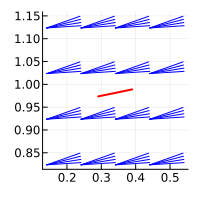

In [253]:
p = Pose(rand(3))
dx  = 0.1
dhd = 4/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(ps, c=:blue, r=0.1, linewidth=1)
plot!(p, c=:red, r=0.1, linewidth=2)
mypl

### Eval pose grid

Needs raycaster and gm-centers and sensor smc logpdf from "src/sensor.jl".

In [293]:
#nbx
"""
"""
function eval_poses(
            ps_::CuArray,
            x::Matrix, 
            segs_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0)
    
    # Compute measurements and gm centers
    zs_      = cast_cu(ps_, segs_)
    ys_tilde_ = get_ys_tilde_cu(zs_, as_, w)
        
    # Evaluate the gm's
    x_ = CuArray(x)
    log_p_ = sensor_smc_logpdf_cu(x_, ys_tilde_, s_noise, outlier, outlier_vol);
    
    # Back to CPU
    ps    = Vector.(eachrow(Array(ps_)))
    log_p = Array(log_p_)

    
    # Sort by log prob
    # and return 
    perm  = sortperm(log_p)
    log_p = log_p[perm]
    ps    = ps[perm]
    
    return ps, log_p
end

eval_poses

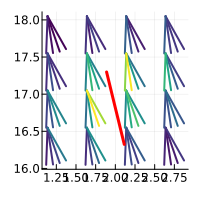

In [308]:
p = _ps[1]
dx  = 0.5
dhd = 10/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

x = stack(polar_inv(_zs[1],_as))

s_noise = 0.2
outlier = 0.1
outlier_vol = 1.0
w = 4

ps, log_ps = eval_poses(ps_, x, vcat(segs_,boxes_), as_, w, s_noise, outlier, outlier_vol)

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(Pose.(ps), cs; r=.5, linewidth=2)
plot!(p, c=:red, r=1., linewidth=3)
mypl

### Grid proposal



In [311]:
#nbx
function filter_infs(ps, log_p)
    good = log_p .!= -Inf
    return ps[good], log_p[good]
end

@dist function labeled_cat(labels, probs)
    index = categorical(probs)
    labels[index]
end

@gen function grid_proposal(p::Pose, x::Matrix{Float64}, 
            k, dx, dhd,
            segs_, as_, w::Int, 
            s_noise::Float64, outlier::Float64, outlier_vol::Float64=1.0)
    
    ps_        = pose_grid(p, k, dx, dhd)
    ps, log_ps = eval_poses(ps_, x, segs_, as_, w, s_noise, outlier, outlier_vol)
    
#     ps, log_p = filter_infs(ps, log_ps)
    
    probs = exp.(log_ps .- logsumexp(log_ps))
    j = categorical(probs)
    p_vec = {:grid_pose} ~ labeled_cat(ps, probs)
    return Pose(p_vec), ps, log_ps
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Pose, Matrix{Float64}, Any, Any, Any, Any, Any, Int64, Float64, Float64, Float64], true, Union{Nothing, Some{Any}}[nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, nothing, Some(1.0)], var"##grid_proposal#1527", Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], false)

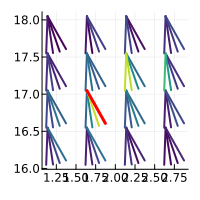

In [427]:
p = _ps[1]
dx  = 0.5
dhd = 10/360*2π
k   = 4
ps_ = pose_grid(p, k, dx, dhd)
ps  = [Pose(Vector(v)) for v in eachrow(Array(ps_))]

x = stack(polar_inv(_zs[1],_as))

s_noise = 0.1
outlier = 0.1
outlier_vol = 1.00
w = 10

q, ps, log_ps = grid_proposal(p, x, k, dx, dhd, segs_, as_, w, s_noise, outlier, outlier_vol)

probs = exp.(log_ps .- logsumexp(log_ps))

cs = cgrad(:viridis)[peak_to_peak(log_ps)]
# cs = cgrad(:viridis)[probs]
# -----------------------------
mypl = plot(size=(200,200), legend=nothing)
plot!(Pose.(ps), cs; r=.5, linewidth=2)
# plot!(p, c=:red, r=.5, linewidth=3)
plot!(q, c=:red, r=.5, linewidth=3)
mypl

### Iterated Proposal

In [ ]:
#nbx
@gen function iterated_proposal(p::Pose, x::Matrix, 
                                w::Vector{Int}, sig::Vector{Float64}, dropout::Vector{Float64}, 
                                grid_k::Vector{Int}, grid_dx::Vector{Float64}, grid_dhd::Vector{Float64})
    
    n = length(w)
    
    ps = Pose[]
    log_ps = []
    for i=1:n
        args = (p, x, w[i], sig[i], dropout[i], grid_k[i], grid_dx[i], grid_dhd[i])
        p, _, log_p = {  i => :p } ~ grid_proposal(args...)
        push!(ps, p)
        push!(log_ps, log_p)
    end
    return p, ps, log_ps
end;

In [428]:
#nbx
function extend(tr, obs, grid_args)

    args  = get_args(tr)    
    diffs = argdiffs([1;fill(0,length(args))])
    t = args[1]    
    x = stack(obs[:chain => t+1 => :sensor => :x])
    
    p = get_last_pose(tr)
    proposal_tr = simulate(iterated_proposal, (p, x, grid_args...));
    proposal_sc = get_score(proposal_tr)
    p′, = proposal_tr[];
    
    
    ch = choicemap()
    ch[:chain => t+1 => :pose => :x]  = p′.x
    ch[:chain => t+1 => :pose => :hd]  = p′.hd
        
    tr′,w′,_,_ = Gen.update(tr,(t+1,args[2:end]...),diffs,merge(obs,ch))
    
    return tr′, w′ - proposal_sc
    
end

extend (generic function with 1 method)